# ROOT Basic Tools: histograms and graphs

# 🧱 ROOT histograms

[Histogram class documentation](https://root.cern.ch/doc/master/classTH1.html)

ROOT has powerful histogram objects that, among other features, let you produce complex plots and perform fits of arbitrary functions.

Below is an example histogram that can be obtained using one of our tutorials: [Higgs to Four Leptons](https://root.cern/doc/master/df106__HiggsToFourLeptons_8py.html). 

`TH1D` is a 1D histogram with floating point double precision y-axis, `TH2I` is a 2D histogram with Integer y-axis, etc.

<center><img src="../images/examplehist_df106_HiggsToFourLeptons.png"></center>

## 🪆 Creating and filling a histogram

To have something to play with, let's quickly fill a histogram with 5000 normally distributed values:

In [1]:
import ROOT
import numpy as np

In [2]:
h1d_gaus = ROOT.TH1D(name="h1d_gaus", title="My histo", nbinsx=100, xlow=-5, xup=5)
h1d_gaus.FillRandom("gaus", ntimes=5000)

You can find the full list of supported expressions [here](https://root.cern/doc/master/classTFormula.html).
To check the full documentation you can always refer to https://root.cern/doc/master (and then switch to the documentation for your particular ROOT version with the drop-down menu at the top of the page).

## 📊 Drawing a histogram

[Drawing options documentation](https://root.cern.ch/doc/master/classTHistPainter.html)

The link above contains the documentation for the histogram drawing options.

In a notebook, we want to use the `%jsroot on` magic and explicitly draw a `TCanvas`.

In [3]:
%jsroot on
c = ROOT.TCanvas()
#h1d_gaus.SetLineColor(ROOT.kBlue)
#h1d_gaus.SetFillColor(ROOT.kBlue)
#h1d_gaus.GetXaxis().SetTitle("value")
#h1d_gaus.GetYaxis().SetTitle("count")
#h1d_gaus.SetTitle("My histo with latex: p_{t}, #eta, #phi")
h1d_gaus.Draw() # draw the histogram on the canvas
c.Draw() # draw the canvas on the screen

## 🎯 Projections

Often, we want to study how one or more variables behave while integrating over the others.
ROOT provides projection methods that allow us to extract lower-dimensional histograms: for example, projecting a 2D or 3D histogram onto one axis to obtain a 1D distribution of a single observable.

See [Projections of histograms](https://root.cern.ch/doc/v636/classTH1.html#prof-hist) for more details.

Here we’ll:
- Fill a 2D histogram with Gaussian-distributed data
- Compute and draw its projections along **X** and **Y**

In [4]:
from ROOT import gRandom

# Create a 2D histogram
h2d_gaus = ROOT.TH2D("h2d_gaus", "2D Gaussian;X;Y", 25, -5, 5, 50, -5, 5)

# Fill with Gaussian-distributed data
for i in range(50000):
    x = gRandom.Gaus(0, 1)
    y = gRandom.Gaus(0, 1)
    h2d_gaus.Fill(x, y)

# Compute projections
hpx = h2d_gaus.ProjectionX("hpx")
hpy = h2d_gaus.ProjectionY("hpy")

In [5]:
# Draw the 2D histogram
c_proj = ROOT.TCanvas("c_proj", "2D Gaussian and Projections", 1000, 400)
c_proj.Divide(2, 1)
c_proj.cd(1)
h2d_gaus.Draw("COLZ")

# Draw projections
c_proj.cd(2)
hpx.SetLineColor(ROOT.kBlue)
hpy.SetLineColor(ROOT.kRed)
hpx.SetTitle("Projections;Value;Entries")
hpx.Draw()
hpy.Draw("SAME")

c_proj.Draw()

## 🧩 The Unified Histogram Interface (UHI)

ROOT histograms now implement the **[Unified Histogram Interface (UHI)](https://uhi.readthedocs.io/en/latest/)**, which provides a **Pythonic interface** for working with histograms.  

Think of it as an **interface layer**: it doesn’t change the underlying ROOT histogram implementation, but it allows you to manipulate histograms using **NumPy-like syntax**, slice them, and integrate more naturally with Python plotting tools such as [`mplhep`](https://mplhep.readthedocs.io/en/latest/).

More details and examples can be found in the [UHI documentation](https://uhi.readthedocs.io/en/latest/) and [ROOT UHI reference](https://root.cern.ch/doc/master/group__uhi__docs.html).

> **Note:** For the following cells, **ROOT ≥ 6.36** is required.  
> If you encounter errors, check your ROOT version. If it is lower than 6.36, you can skip these cells and continue with the ROOT functions section.


To quickly try it out, let's set the content of a `TH1D` and plot it:

In [6]:
from ROOT.uhi import loc, overflow, rebin, sum, underflow
import matplotlib.pyplot as plt
import mplhep as hep
import seaborn as sns

In [7]:
# There is a difference between filling and setting a histogram
h_fill_set = ROOT.TH1D("h", "Fill vs SetBinContent", 3, 0, 3)

# Fill() -> adds data to the histogram
h_fill_set.Fill(2.5)

print("After Fill(2.5):", h_fill_set.values())

# SetBinContent() -> modifies the bin contents manually
h_fill_set.Reset()
h_fill_set.SetBinContent(1, 2.5)

print("\nAfter SetBinContent(1, 2.5):", h_fill_set.values())


After Fill(2.5): [0. 0. 1.]

After SetBinContent(1, 2.5): [2.5 0.  0. ]


In [8]:
h1d_uhi_basic = ROOT.TH1D(name="h1d_uhi_basic", title="My UHI histo", nbinsx=10, xlow=0, xup=1)

# Setting the histogram content using UHI-style indexing syntax
h1d_uhi_basic[...] = np.linspace(0, 11, 12)  # set with 0..11, including under/overflow

"""
# equivalent native ROOT-style loop for setting bin contents
values = np.linspace(0, 11, 12)
for i in range(0, h1d_uhi_basic.GetNbinsX() + 2):  # +2 to include under/overflow
    h1d_uhi_basic.SetBinContent(i, values[i])
"""

print(f"Bin contents: {h1d_uhi_basic.values()}")
print(f"Underflow: {h1d_uhi_basic[underflow]}, Overflow: {h1d_uhi_basic[overflow]}")

Bin contents: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Underflow: 0.0, Overflow: 11.0


### 💡 Hint

| **UHI Expression**     | **Equivalent ROOT Function**     | **Description**                          |
|------------------------:|:---------------------------------|:-----------------------------------------|
| `h[bin] = value`          | `h.SetBinContent(bin+1, value)` | Set the content of a specific bin           |
| `h[bin]`          | `h.GetBinContent(bin+1)`               | Access the content of a specific bin           |
| `h[underflow]`        | `h.GetBinContent(0)`                    | Access the underflow bin               |
| `h[overflow]`     | `h.GetBinContent(nbins+1)`         | Access overflow bin    |

/Users/siliataider/Documents/student-course/rootenev/lib/python3.13/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)


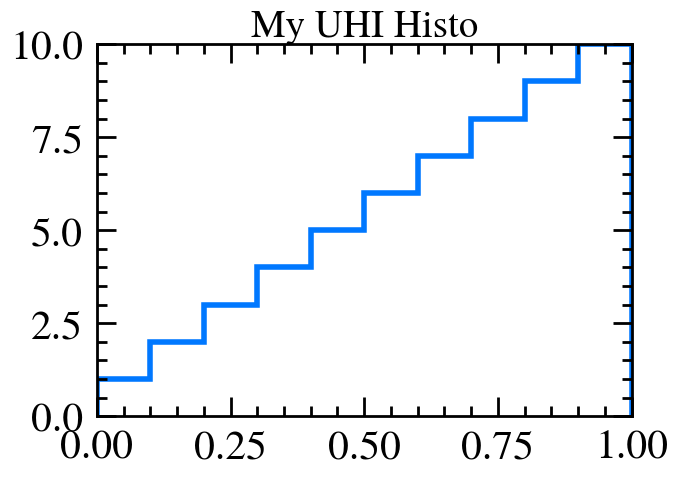

In [9]:
hep.style.use("LHCb2")  # set the style to LHCb2

plt.figure(figsize=(7,5))
hep.histplot(
    h1d_uhi_basic,
    yerr=False,
    linewidth=4,
)
plt.title("My UHI Histo")
plt.show()

**Exercise:** Using `NumPy`’s [`np.histogram`](https://numpy.org/doc/2.1/reference/generated/numpy.histogram.html#numpy-histogram), fill a histogram that matches the distribution of `h1d_gaus` above, and plot it using `mplhep`:

/Users/siliataider/Documents/student-course/rootenev/lib/python3.13/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)


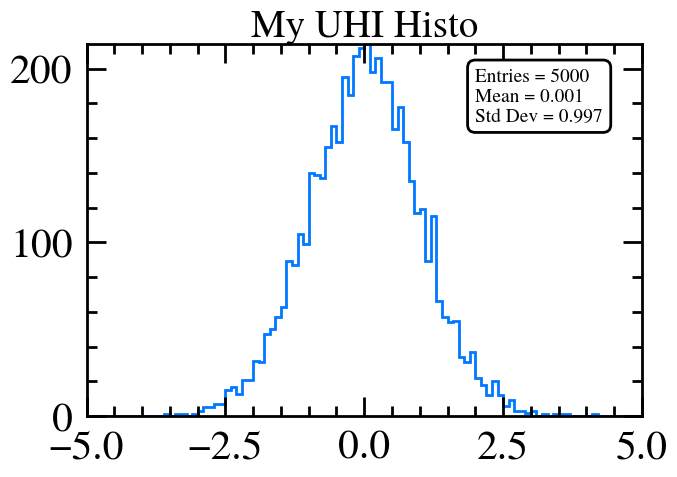

In [10]:
# Solution
h1d_uhi_gauss = ROOT.TH1D(name="h1d_uhi_gauss", title="My UHI histo", nbinsx=100, xlow=-5, xup=5)
h1d_uhi_gauss[...] = np.histogram(np.random.normal(size=5000), bins=100, range=(-5,5))[0]
# or call h1d_uhi_gauss.Fill(np.random.normal(size=5000))

entries = h1d_uhi_gauss.GetEntries()
mean = h1d_uhi_gauss.GetMean()
std = h1d_uhi_gauss.GetStdDev()

plt.figure(figsize=(7,5))
hep.histplot(h1d_uhi_gauss, linewidth=2, yerr=False)
plt.title("My UHI Histo")

stats_text = (
    f"Entries = {entries:.0f}\n"
    f"Mean = {mean:.3f}\n"
    f"Std Dev = {std:.3f}"
)

plt.text(
    2, 170, stats_text,
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white")
)

plt.show()

To demonstrate more advanced UHI functionalities, we will create a 2D histogram, fill it using `NumPy` and perfom slicing and projection operations (see [hist019_TH2_projection.C](https://root.cern/doc/master/hist019__TH2__projection_8C.html) for the original code)

In [11]:
h2d = ROOT.TH2D("h2d", "", 40, -4, 4, 40, -20, 20)

h2d[...] = np.histogram2d(
    np.random.normal(0, 1, 25000), 5*np.random.normal(0, 1, 25000), bins=(40, 40), range=[[-4, 4], [-20, 20]]
)[0]

🔪 UHI allows you to slice ROOT histograms using familiar Python slice syntax.

Slicing occurs when [Python slice](https://docs.python.org/3/c-api/slice.html) are passed in brackets:

`histogram[start:stop:action]`

This lets you easily select or transform parts of your histogram.

In [12]:
projh2X = h2d[::sum, :] # 1D projection on Y axis
projh2Y = h2d[:, ::sum] # 1D projection on X axis

projh2X_rebinned = projh2X[::rebin(5)] # rebinning by a factor 2
projh2X_sliced = projh2X[loc(0):] # slice X projection starting from data point 0

### 💡 Hint

| **UHI Expression**     | **Equivalent ROOT Function**     | **Description**                          |
|------------------------:|:---------------------------------|:-----------------------------------------|
| `h2[::sum, :]`          | `h2.ProjectionY()`               | Projection onto the **Y** axis           |
| `h2[:, ::sum]`          | `h2.ProjectionX()`               | Projection onto the **X** axis           |
| `h2[::rebin(2)]`        | `h2.Rebin(2)`                    | Rebinning by a factor of 2               |
| `h2[loc(a):loc(b)]`     | ❌ *(no direct equivalent)*         | Slicing between positions `a` and `b`    |

/Users/siliataider/Documents/student-course/rootenev/lib/python3.13/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/Users/siliataider/Documents/student-course/rootenev/lib/python3.13/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/Users/siliataider/Documents/student-course/rootenev/lib/python3.13/site-packages/mplhep/utils.py:365: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  _plottable.errors(assume_variances_equal_values=True)
/Users/siliataider/Documents/student-course

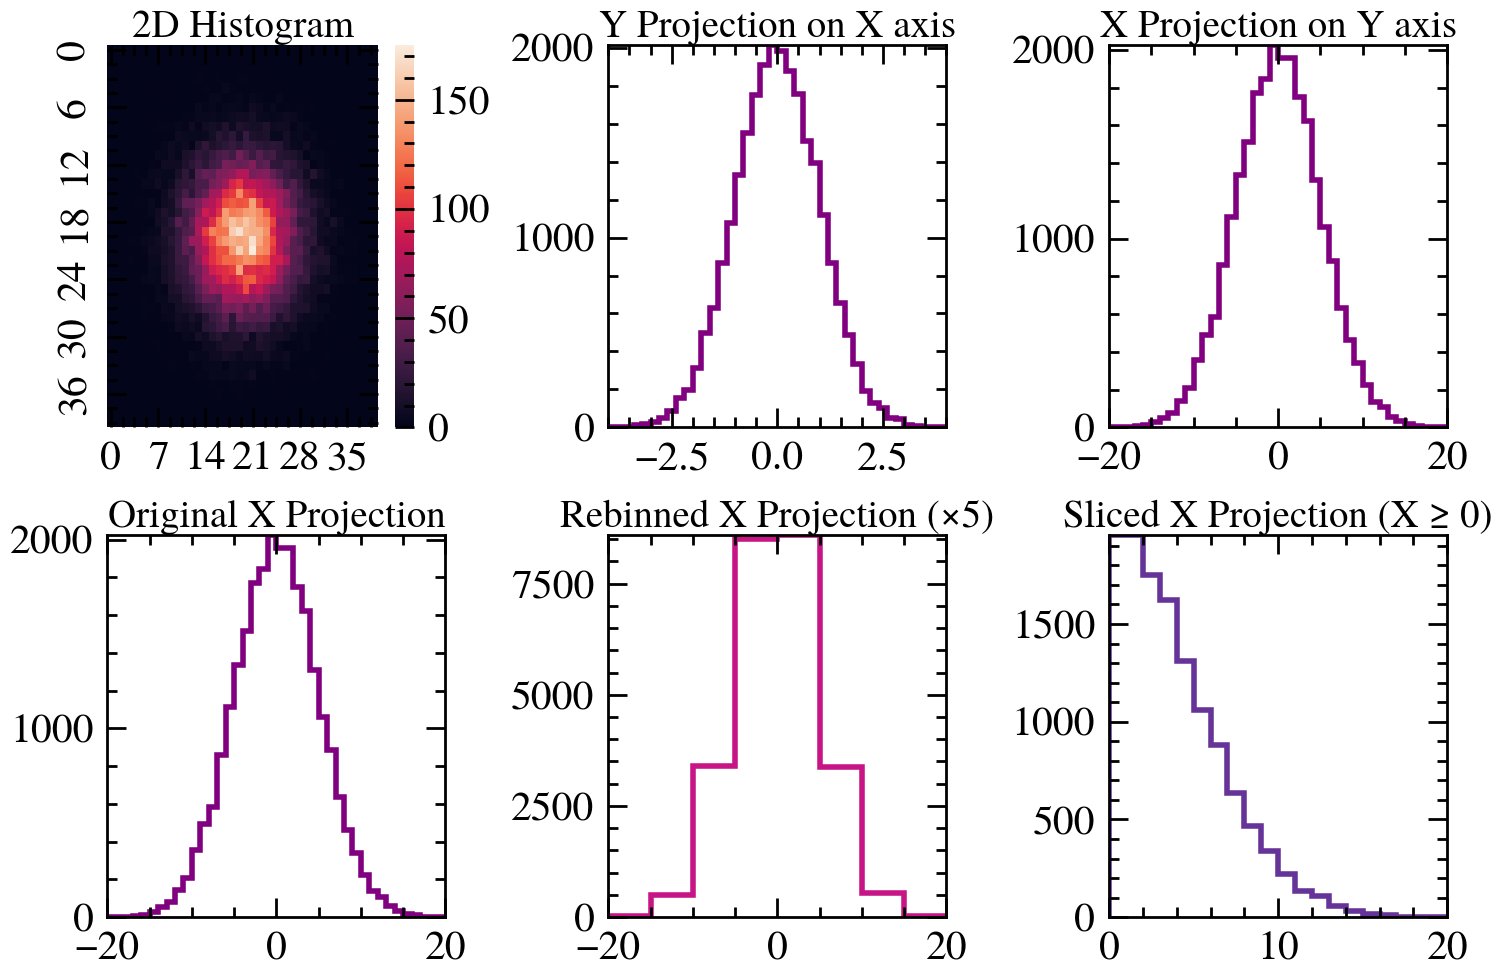

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row: 2D histogram + projections X and Y
sns.heatmap(h2d.values(), ax=axes[0, 0])
axes[0, 0].set_title("2D Histogram")

hep.histplot(projh2Y, ax=axes[0, 1], histtype="step", color="purple", linewidth=4, yerr=False)
axes[0, 1].set_title("Y Projection on X axis")

hep.histplot(projh2X, ax=axes[0, 2], histtype="step", color="purple", linewidth=4, yerr=False)
axes[0, 2].set_title("X Projection on Y axis")

# Second row: X projection transformations
hep.histplot(projh2X, ax=axes[1, 0], histtype="step", color="purple", linewidth=4, yerr=False)
axes[1, 0].set_title("Original X Projection")

hep.histplot(projh2X_rebinned, ax=axes[1, 1], histtype="step", color="mediumvioletred", linewidth=4, yerr=False)
axes[1, 1].set_title("Rebinned X Projection (×5)")

hep.histplot(projh2X_sliced, ax=axes[1, 2], histtype="step", color="rebeccapurple", linewidth=4, yerr=False)
axes[1, 2].set_title("Sliced X Projection (X ≥ 0)")

plt.show()

# 🧮 Modeling and Fitting Data

## 🎛️ ROOT functions

The type that represents an arbitrary one-dimensional mathematical function in ROOT is [TF1](https://root.cern.ch/doc/master/classTF1.html).<br>
Similarly, [TF2](https://root.cern.ch/doc/master/classTF2.html) and [TF3](https://root.cern.ch/doc/master/classTF3.html) represent 2-dimensional and 3-dimensional functions.

As an example, let's define and plot a simple surface:

In [14]:
f2 = ROOT.TF2("f2", "sin(x*x - y*y)", xmin=-2, xmax=2, ymin=-2, ymax=2)

In [15]:
c = ROOT.TCanvas()
f2.Draw("surf1") # to get a surface instead of the default contour plot
c.Draw()

## 📈 Fitting a histogram

Let's see how to perform simple histogram fits of arbitrary functions. We will need a `TF1` that represents the function we want to use for the fit.

This time we define our `TF1`. Here we define a simple gaussian with scale and mean parameters (pars[0] and pars[1] respectively):

In [16]:
def gaussian(x: np.ndarray, pars: np.ndarray) -> float:    
    return pars[0] * np.exp(-np.power(x[0] - pars[1], 2) / 2) / np.sqrt(2 * np.pi)

The function signature, that takes an array of coordinates and an array of parameters as inputs, is the generic signature of functions that can be used to construct a `TF1` object:

In [17]:
fitFunc = ROOT.TF1("fitFunc", gaussian, xmin=-5, xmax=5, npar=2)

Now we fit our `h` histogram with `fitFunc`:

In [18]:
res = h1d_gaus.Fit(fitFunc, "S") # the "S" option makes the function return a fit result object

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.2302
NDf                       =           67
Edm                       =  1.34911e-09
NCalls                    =           44
p0                        =      494.933   +/-   7.03982     
p1                        =    0.0173689   +/-   0.0142894   


Drawing the histogram now automatically also shows the fitted function:

In [19]:
c2 = ROOT.TCanvas()
h1d_gaus.Draw()
c2.Draw()

For the particular case of a gaussian fit, we could also have used the built-in `"gaus"` function, as we did when we called `FillRandom`.

In [20]:
res = h1d_gaus.Fit("gaus", "S")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      57.2152
NDf                       =           66
Edm                       =  9.31601e-06
NCalls                    =           55
Constant                  =      197.704   +/-   3.46748     
Mean                      =    0.0172556   +/-   0.014353    
Sigma                     =      0.99873   +/-   0.0103909    	 (limited)


In [21]:
c3 = ROOT.TCanvas()
h1d_gaus.Draw()
c3.Draw()

## 🧠 Introduction to RooFit

For more complex binned and unbinned likelihood fits, [RooFit](https://root.cern/manual/roofit/) is the way to go.

You just saw how to fit a histogram using `TH1::Fit` with a `TF1` function. **RooFit** works on the same basic idea:

* You have data, e.g., a histogram of measured values.
* You have a model  expressed by a probability density funciton -- or PDF, e.g., a Gaussian function describing what you expect your data to look like.
* You fit the model to the data to find the best parameters (like mean and width).

Let’s see how to use **RooFit** to fit a Gaussian model to our histogram data:

In [22]:
from ROOT import RooRealVar, RooDataHist, RooGaussian, RooFit

# define the observable corresponding to the histogram axis
x = RooRealVar("x", "x", -5, 5)

# create a binned dataset that imports contents of ROOT.TH1 and associates
# its contents to observable 'x'
data = RooDataHist("data", "Dataset from histogram", [x], Import=h1d_gaus)

# define the model: a Gaussian PDF with mean and sigma as parameters
mean = RooRealVar("mean", "mean", 0, -5, 5)
sigma = RooRealVar("sigma", "sigma", 1, 0.1, 3)
gauss = RooGaussian("gauss", "gauss", x, mean, sigma)

# fit the model to the data
gauss.fitTo(data, PrintLevel=0)

# plot the data and the fitted PDF
frame = x.frame(Title="RooFit Gaussian fit to histogram")
data.plotOn(frame)
gauss.plotOn(frame)

c = ROOT.TCanvas("c", "RooFit Fit", 800, 600)
frame.Draw()
c.Draw()


[#1] INFO:Fitting -- RooAbsPdf::fitTo(gauss_over_gauss_Int[x]) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- using generic CPU library compiled with no vectorizations
[#1] INFO:Fitting -- Creation of NLL object took 3.11342 ms
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_gauss_over_gauss_Int[x]_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- [fitFCN] No discrete parameters, performing continuous minimization only
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 7170.26985204977791
Edm   = 9.6639093702108458e-07
Nfcn  = 29
mean	  = 0.00882102	 +/-  0.0143576	(limited)
sigma	  = 1.01523	 +/-  0.0101534	(limited)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization


Unlike a simple `TH1::Fit`, **RooFit** allows you to:

- Fit binned or unbinned data.
- Work with multiple observables simultaneously (multi-dimensional fits).
- Build composite models.
- Generate toy datasets from models for testing or simulations.
- Inspect parameter uncertainties, correlations, and likelihoods in detail.

> 📚 If you want to explore RooFit in more depth and try additional examples, check out the [RooFit Tutorial: Introduction to Unbinned Likelihood Models](https://github.com/root-project/training/blob/master/RooFit/roofit-tutorial-01.ipynb)

# 🎨 Visualizing and Combining Results

## 📉 ROOT graphs

[TGraph](https://root.cern/doc/master/classTGraph.html) is a type useful for scatter plots.

Their drawing options are documented [here](https://root.cern/doc/master/classTGraphPainter.html).

Like for histograms, the aspect of `TGraph`s can be greatly customized, they can be fitted with custom functions, etc. 

In [23]:
x = np.arange(-20, 21, dtype=float)
y = -x*x
g = ROOT.TGraph(n=x.size, x=x, y=y)

c4 = ROOT.TCanvas()
g.SetMarkerStyle(7)
g.SetLineColor(ROOT.kBlue)
g.SetTitle("My graph")
g.Draw()
c4.Draw()

The same graph can be displayed as a bar plot:

In [24]:
c5 = ROOT.TCanvas()
g.SetTitle("My graph")
g.SetFillColor(ROOT.kOrange + 1) # base colors can be tweaked by adding/subtracting values to them 
g.Draw("AB1")
c5.Draw()

## Plot example: histogram stack

In HEP, we often plot stacked histograms, for example to show the
contributions of different processes. This can be done with [THStack](https://root.cern.ch/doc/master/classTHStack.html).

In [25]:
f1 = ROOT.TF1("f1", "gaus", -4.0, 4.0)

histos = [ROOT.TH1D(f"h{i}", "x", 64, -4.0, 4.0) for i in range(3)]

hs = ROOT.THStack("hs","")
hs.SetTitle(";x;Events")

colors = [46, 30, 38]
        
for i in range(len(histos)):
    h = histos[i]
    f1.SetParameters(1.0, i - 1, 1.0)
    h.FillRandom("f1", 100000)
    h.SetFillColor(colors[i])
    hs.Add(h)

c6 = ROOT.TCanvas()
hs.Draw()
c6.Draw()

## Plot example: efficiency curves

Another common workflow is to draw efficiency curves with [TEfficiency](https://root.cern.ch/doc/master/classTEfficiency.html), which also gives uncertainties.

In [26]:
h_pass = ROOT.TH1D("h_pass", "My histogram", 50, 0, 100.0)
h_total = ROOT.TH1D("h_total", "My histogram", 50, 0, 100.0)

f_gaus = ROOT.TF1("f_gaus", "gaus", 0, 100.0)

f_gaus.SetParameters(1.0, 56.0, 20.0)
h_pass.FillRandom("f_gaus", 40000)
h_pass.SetLineColor(ROOT.kRed)
f_gaus.SetParameters(1.0, 50.0, 20.0)
h_total.FillRandom("f_gaus", 100000)

In [27]:
teff = ROOT.TEfficiency(h_pass,h_total)

c7 = ROOT.TCanvas("rf101_basics", "rf101_basics", 800, 400)
c7.Divide(2)
c7.cd(1)
h_total.Draw()
h_pass.Draw("SAME")
c7.cd(2)
teff.Draw()
c7.Draw()